# Logistic Regression as a Neural Network 
(partly following deeplearning.ai lab)

    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

import scipy
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('bioresponse.csv')
X = df.iloc[:, 1:]
y = df.Activity.values

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75)

## General Architecture of the algorithm ##


Build a Logistic Regression, using a Neural Network mindset.

**Logistic Regression is actually a very simple Neural Network!**


**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})$$

Key steps:

  -Initialize the parameters of the model

  -Learn the parameters for the model by minimizing the cost  

  -Use the learned parameters to make predictions (on the test set)
  
  -Analyse the results and conclude

## Parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features, number of layers, number of neurons in the layer etc.) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

Build 1-3 separately and integrate them into one function we call `model()`.

### Sigmoid

$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ 

In [4]:
def sigmoid(z):

    s = 1./(1.+np.exp(-z))
    
    return s

### Initializing parameters



In [5]:
def initialize_with_zeros(dim):

    w = np.zeros((dim,1))
    b = 0.
    
    return w, b

### Forward and Backward propagation

Implement a function `propagate()` that computes the cost function and its gradient.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas we should use: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [6]:
def propagate(w, b, X, Y):

    m = X.shape[1]

    A = sigmoid(np.dot(w.T,X)+b )                                 # compute activation
    cost = -(1./m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A),axis=1)   # compute cost

    dw = (1./m)*np.dot(X,(A-Y).T)
    db = (1./m)*np.sum(A-Y,axis=1)

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### Optimization
- We have initialized the parameters.
- We are able to compute a cost function and its gradient.
- Now, we have to update the parameters using gradient descent.

For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [7]:
def gd(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

    costs = []
    
    for i in range(num_iterations):

        grads, cost = propagate(w,b,X,Y)

        dw = grads["dw"]
        db = grads["db"]

        w -=learning_rate*dw
        b -=learning_rate*db

        if i % 100 == 0:
            costs.append(cost)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [8]:
def sgd(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

    costs = []

    for i in range(num_iterations):
        index = np.random.choice(X.shape[1], size=1, replace=False)[0]

        grads, cost = propagate(w,b,np.expand_dims(X[:,index],axis=1),Y[index])

        dw = grads["dw"]
        db = grads["db"]

        w -=learning_rate*dw
        b -=learning_rate*db

        if i % 100 == 0:
            costs.append(cost)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [9]:
def adam_optimization(w, b, X, Y, num_iterations, learn_rate, print_cost = False, beta_1=0.9, beta_2=0.999, e=1e-8):

    costs = []

    first_moment_w = np.random.random((X.shape[0], 1))
    second_moment_w = np.random.random((X.shape[0], 1))
    first_unbias_w = np.random.random((X.shape[0], 1))
    second_unbias_w = np.random.random((X.shape[0], 1))

    first_moment_b = np.random.random()
    second_moment_b = np.random.random()
    first_unbias_b = np.random.random()
    second_unbias_b = np.random.random()

    iter = 0
    for i in range(num_iterations):
        iter += 1

        grads, cost = propagate(w,b,X,Y)

        dw = grads["dw"]
        db = grads["db"]

        first_moment_w = beta_1 * first_moment_w + (1 - beta_1)*dw
        second_moment_w = beta_2 * second_moment_w + (1 - beta_2)*dw**2
        first_unbias_w = first_moment_w / (1 - beta_1**iter)
        second_unbias_w = second_moment_w / (1 - beta_2**iter)

        first_moment_b = beta_1 * first_moment_b + (1 - beta_1)*db
        second_moment_b = beta_2 * second_moment_b + (1 - beta_2)*db**2
        first_unbias_b = first_moment_b / (1 - beta_1**iter)
        second_unbias_b = second_moment_b / (1 - beta_2**iter)

        w -= learn_rate * np.divide( first_unbias_w, (np.sqrt(second_unbias_w) + e) )
        b -= learn_rate * first_unbias_b / (np.sqrt(second_unbias_b) + e)

        if i % 100 == 0:
            costs.append(cost)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

Implement the `predict()` function. There are two steps to compute predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of A into 0 (if activation <= 0.5) or 1 (if activation > 0.5), store the predictions in a vector `Y_prediction`.

In [10]:
def predict(w, b, X):

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)

    A = sigmoid(np.dot(w.T,X)+b)

    for i in range(A.shape[1]):

        if (A[0,i]<=0.5):
            Y_prediction[0][i]=0
        else:
            Y_prediction[0][i]=1

    return Y_prediction


Already have:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## Merge it all into a model ##

    - Y_prediction_test for the predictions on the test set
    - Y_prediction_train for the predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [11]:
def model(X_train, Y_train, X_test, Y_test, optimization, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    # an argument 'optimization' was added in order to perform different optimization algorithms

    w, b = initialize_with_zeros(X_train.shape[0])

    parameters, grads, costs = optimization(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    w = parameters["w"]
    b = parameters["b"]

    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    # print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    train_accuracy = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    test_accuracy = 100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100

    if optimization.__name__ == 'gd':
        name = 'Gradient Descent'
    elif optimization.__name__ == 'sgd':
        name = 'Stochastic Gradient Descent'
    else:
        name = 'Adam Optimization'


    print(name + " train accuracy: {} %".format(train_accuracy))
    print(name + " test accuracy: {} %".format(test_accuracy))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations,
         "train_accuracy": train_accuracy,
         "test_accuracy": test_accuracy}

    return d

Run the following cell to train your model.

In [12]:
gd_model = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=gd, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 1.070961
Cost after iteration 200: 0.860150
Cost after iteration 300: 0.778122
Cost after iteration 400: 0.729150
Cost after iteration 500: 0.697722
Cost after iteration 600: 0.654553
Cost after iteration 700: 0.567666
Cost after iteration 800: 0.678135
Cost after iteration 900: 0.547007
Cost after iteration 1000: 0.554760
Cost after iteration 1100: 0.680621
Cost after iteration 1200: 0.460530
Cost after iteration 1300: 0.491154
Cost after iteration 1400: 0.718320
Cost after iteration 1500: 0.668299
Cost after iteration 1600: 0.536371
Cost after iteration 1700: 0.466869
Cost after iteration 1800: 0.437255
Cost after iteration 1900: 0.427956
Gradient Descent train accuracy: 82.97191610380378 %
Gradient Descent test accuracy: 72.17484008528784 %


Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/


In [13]:
sgd_model = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=sgd, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.000183
Cost after iteration 200: 2.294810
Cost after iteration 300: 0.000042
Cost after iteration 400: 0.003575
Cost after iteration 500: 31.636934
Cost after iteration 600: 0.033796
Cost after iteration 700: 1.714200
Cost after iteration 800: nan
Cost after iteration 900: 8.163336
Cost after iteration 1000: nan
Cost after iteration 1100: 8.263549
Cost after iteration 1200: 0.000000
Cost after iteration 1300: nan
Cost after iteration 1400: 12.726603
Cost after iteration 1500: 0.000000
Cost after iteration 1600: nan
Cost after iteration 1700: 7.462527
Cost after iteration 1800: 0.000000
Cost after iteration 1900: 0.828212
Stochastic Gradient Descent train accuracy: 75.04443654461429 %
Stochastic Gradient Descent test accuracy: 71.42857142857143 %


In [14]:
adam_model = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=adam_optimization, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: nan
Cost after iteration 200: 1.277627
Cost after iteration 300: 0.862893
Cost after iteration 400: 0.663976
Cost after iteration 500: 0.551888
Cost after iteration 600: 0.482122
Cost after iteration 700: 0.438083
Cost after iteration 800: 0.406698
Cost after iteration 900: 0.382434
Cost after iteration 1000: 0.363511
Cost after iteration 1100: 0.348336
Cost after iteration 1200: 0.335742
Cost after iteration 1300: 0.325094
Cost after iteration 1400: 0.316389
Cost after iteration 1500: 0.309104
Cost after iteration 1600: 0.302661
Cost after iteration 1700: 0.296820
Cost after iteration 1800: 0.291446
Cost after iteration 1900: 0.286448
Adam Optimization train accuracy: 88.2332029861358 %
Adam Optimization test accuracy: 74.73347547974413 %


In [15]:
def get_plot(l_rate):
    print('Learning_rate =', l_rate)
    gd_lr_test = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=gd, learning_rate=l_rate, print_cost=False)
    sgd_lr_test = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=sgd, learning_rate=l_rate, print_cost=False)
    adam_lr_test = model(X_train.to_numpy().T, y_train, X_test.to_numpy().T, y_test, optimization=adam_optimization, learning_rate=l_rate, print_cost=False)
    accuracy[l_rate] = [gd_lr_test["train_accuracy"], gd_lr_test["test_accuracy"], sgd_lr_test["train_accuracy"], sgd_lr_test["test_accuracy"], adam_lr_test["train_accuracy"], adam_lr_test["test_accuracy"]]
    iterations = range(0, gd_lr_test["num_iterations"], 100)

    plt.plot(iterations, gd_lr_test["costs"], 'r', label = 'Gradient Descent')
    plt.plot(iterations, sgd_lr_test["costs"], 'b', label = 'Stochastic Gradient Descent')
    plt.plot(iterations, adam_lr_test["costs"], 'g', label = 'Adam Optimization')
    plt.xlabel("N of iterations",fontsize = 10)
    plt.ylabel("Loss function",fontsize = 10)

    plt.title(f'Learning rate: {l_rate}')
    plt.legend(fontsize = 10)

In [16]:
accuracy = pd.DataFrame({'': ['Train accuracy GD', 'Test accuracy GD', 'Train accuracy SGD','Test accuracy SGD', 'Train accuracy Adam','Test accuracy Adam']})

Learning_rate = 6e-06
Gradient Descent train accuracy: 54.10593672236047 %
Gradient Descent test accuracy: 54.58422174840085 %
Stochastic Gradient Descent train accuracy: 54.10593672236047 %
Stochastic Gradient Descent test accuracy: 54.58422174840085 %
Adam Optimization train accuracy: 54.10593672236047 %
Adam Optimization test accuracy: 54.58422174840085 %
Learning_rate = 5e-05
Gradient Descent train accuracy: 54.10593672236047 %
Gradient Descent test accuracy: 54.58422174840085 %
Stochastic Gradient Descent train accuracy: 54.10593672236047 %
Stochastic Gradient Descent test accuracy: 54.58422174840085 %
Adam Optimization train accuracy: 57.518663348738 %
Adam Optimization test accuracy: 58.42217484008529 %
Learning_rate = 0.0004
Gradient Descent train accuracy: 66.37042303590474 %
Gradient Descent test accuracy: 68.12366737739872 %
Stochastic Gradient Descent train accuracy: 62.6377532883043 %
Stochastic Gradient Descent test accuracy: 64.17910447761194 %
Adam Optimization train ac

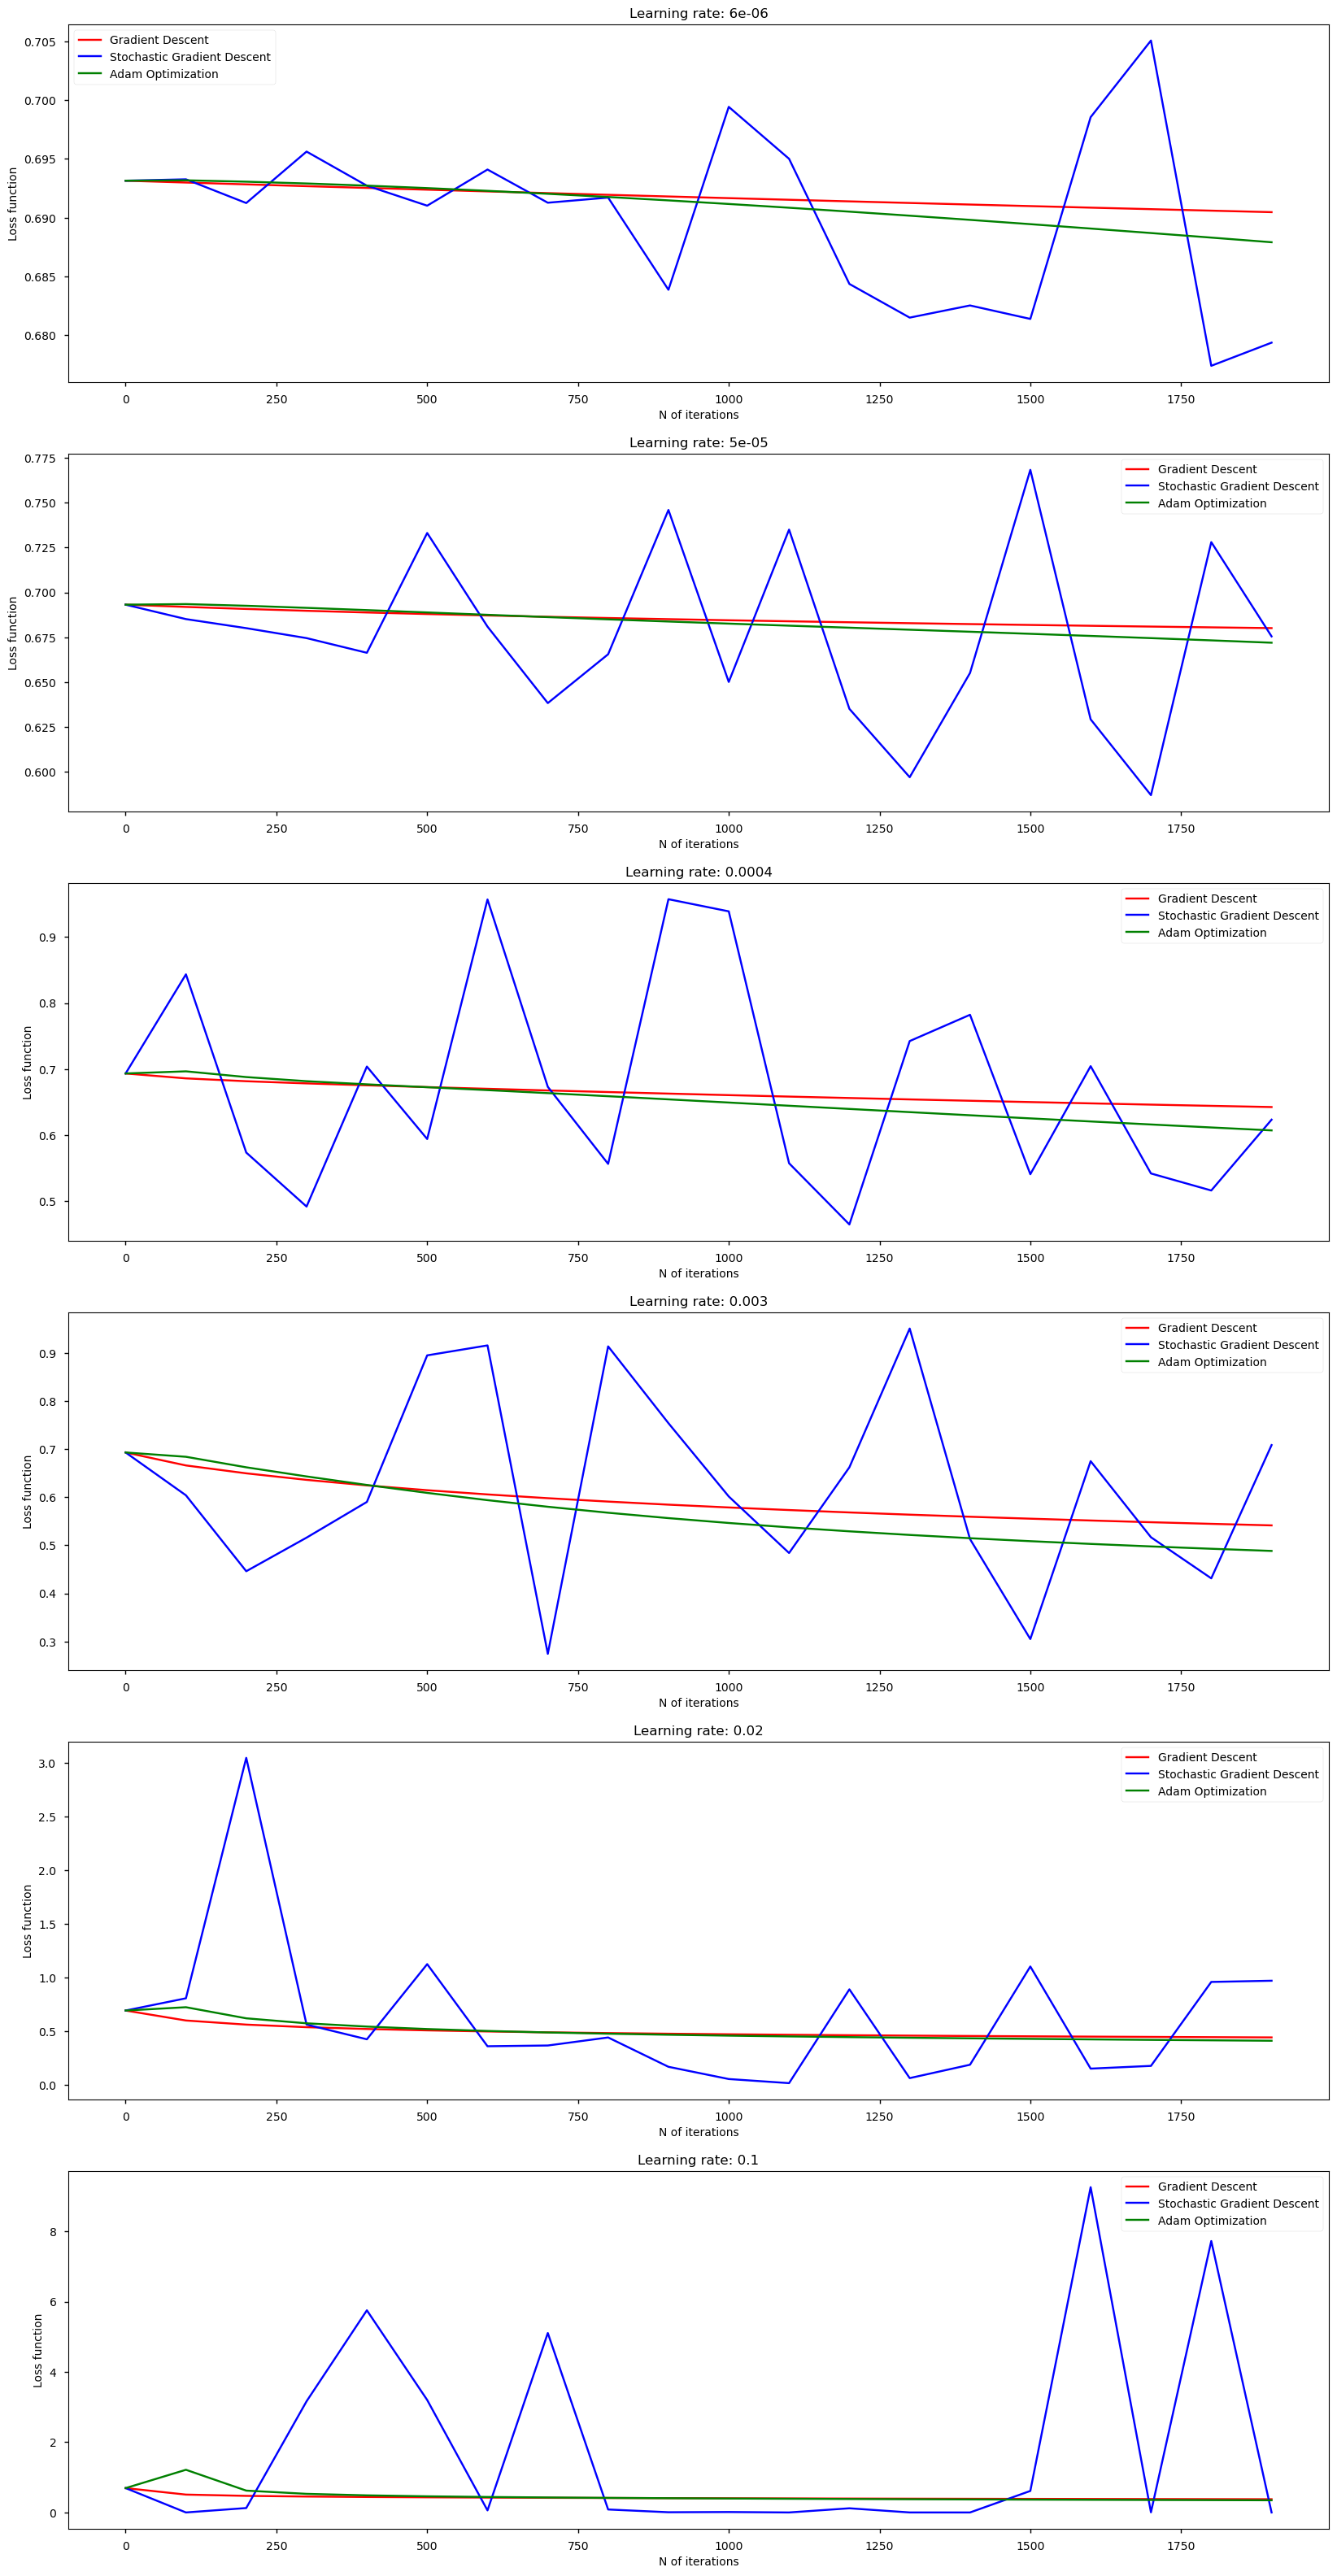

In [17]:
plt.figure(figsize=(20, 40))
plt.style.use('seaborn-notebook')

rate = [6e-6, 5e-5, 4e-4, 3e-3, 2e-2, 1e-1]
for i in range(len(rate)):
    plt.subplot(6, 1, i+1)
    get_plot(rate[i])

In [18]:
accuracy

,,6e-06,5e-05,0.0004,0.003,0.02,0.1
0,Train accuracy GD,54.105937,54.105937,66.370423,75.968717,80.199076,83.860647
1,Test accuracy GD,54.584222,54.584222,68.123667,74.840085,76.226013,76.332623
2,Train accuracy SGD,54.105937,54.105937,62.637753,73.906861,76.928546,74.440100
3,Test accuracy SGD,54.584222,54.584222,64.179104,72.814499,74.093817,71.108742
4,Train accuracy Adam,54.105937,57.518663,71.205119,78.101671,81.621045,85.495912
5,Test accuracy Adam,54.584222,58.422175,72.388060,76.332623,76.759062,76.119403
